# Semestrální práce
### Základem této práce jsou data eurostatu

### 1) Načtení dat a zobrazení první časové řady
##### Prvním krokem bylo načtení dat a zobrazení časové řady, abych se lépe seznámil s charakterem a chováním časové řady.

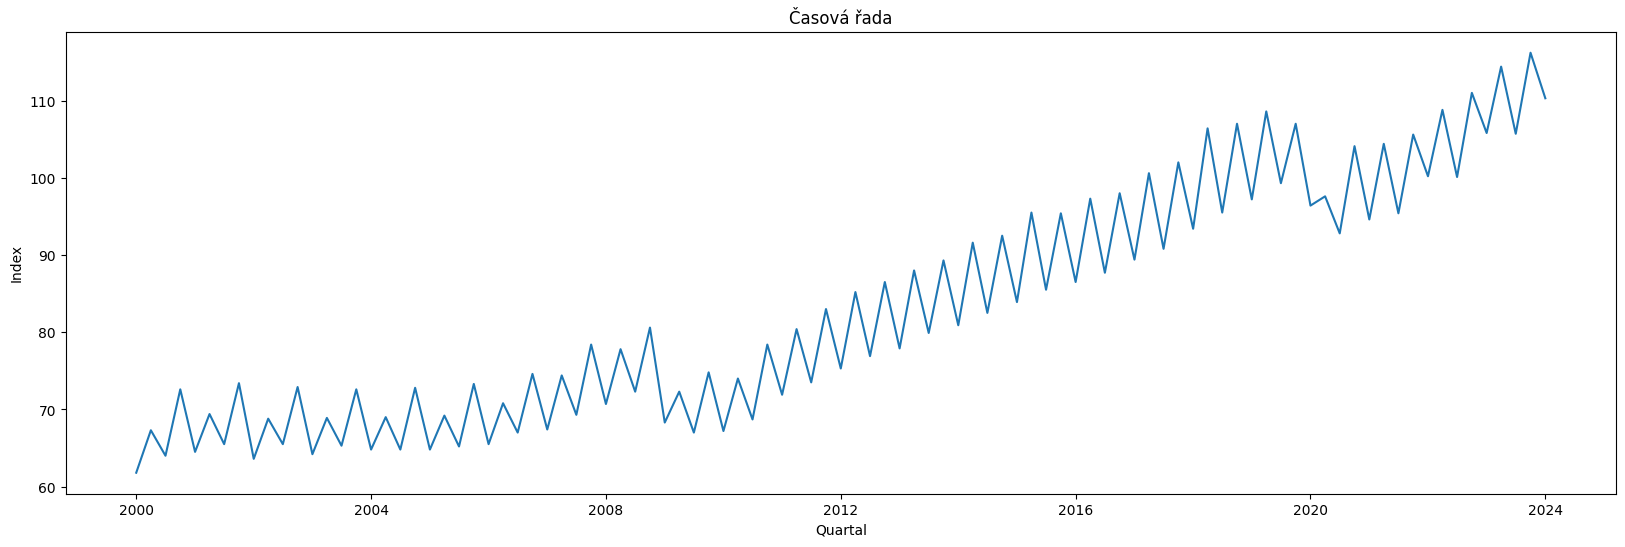

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


# Načtení dat z CSV souboru
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']



plt.figure(figsize=(20, 6))
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.title("Časová řada")
plt.plot(x,y)



##### Po zobrazení časové řady si můžeme všimnout, že v různých obdobích se chování liší:
- První čeho si všímám - každá změna je jeden kvartál
    - Každý sudý vrchol je narůst a každý lichý je pokles, tedy data vypadají, že budou mít sezónní složku
- 2000-2004 -> Zde vidíme už okem, že se hodnoty přiliš nemění
- 2004-2008 -> Zde hodnoty začínají lehce stoupat
- 2008-2010 -> Zde došlu k většímu poklesu, než je obvyklé v předchozích obdobích
- 2010-2020 -> Zde až k roku 2020 hodnoty stále stoupají v podobném stylu
- 2020-konec -> Dochází k "výraznějšímu" poklesu a následně zase hodnoty stoupají

##### Trend se mi nezdá lineární, ale v následujícím kroku se na to podíváme detailněji

### 2) Dekompozice a identifikace trendu
##### Dekompozice časové řady slouží k rozkladu na tři hlavní složky (Trendová, sezónní a náhodná)

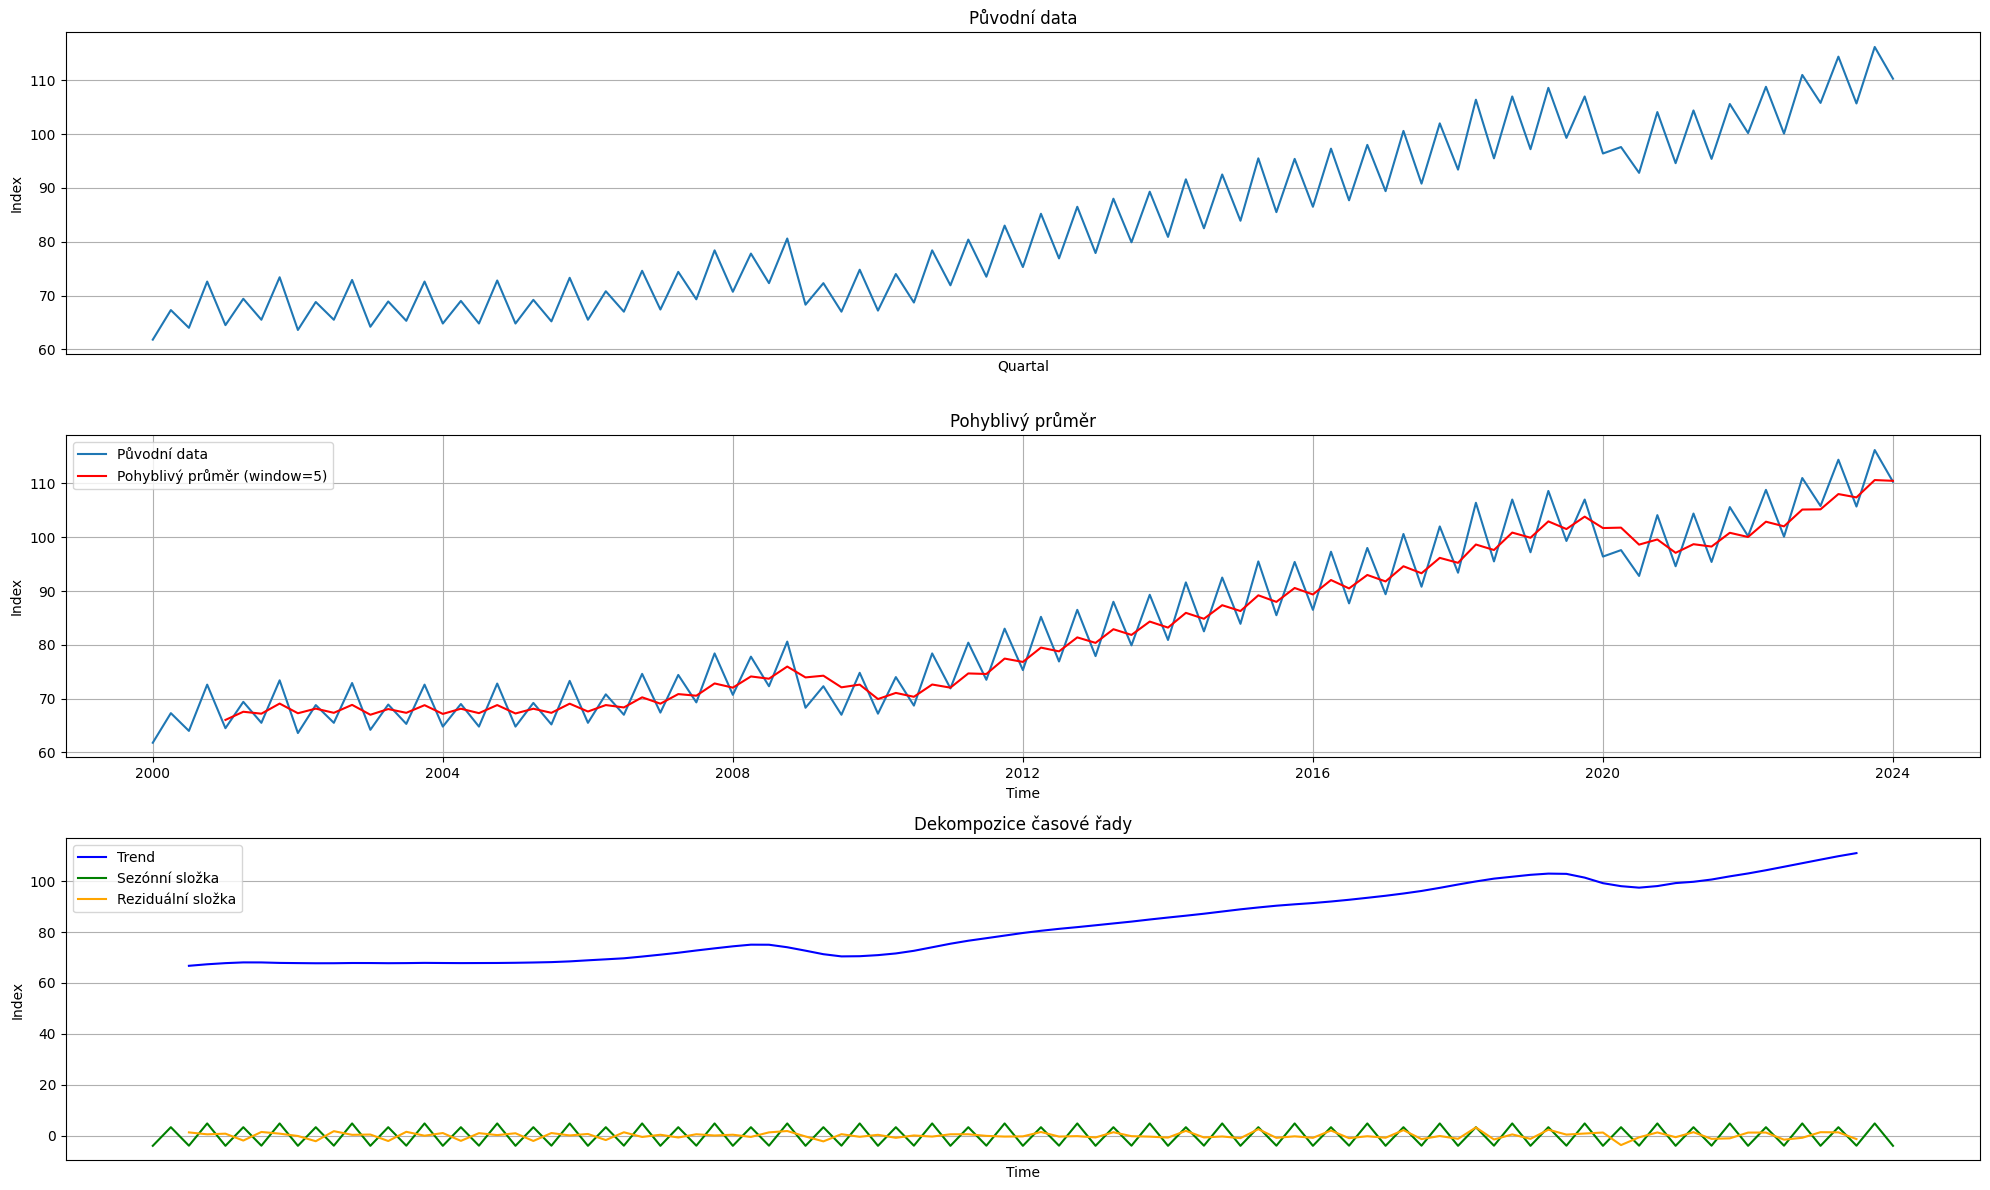

In [20]:
filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])

# Nastavení sloupce s časem jako index
filtered_data.set_index('TIME_PERIOD', inplace=True)

# Ujistěte se, že data jsou seřazena podle času
filtered_data = filtered_data.sort_index()

# Výběr sloupce s hodnotami
data_values = filtered_data['OBS_VALUE']  # Upravte podle skutečného názvu sloupce s hodnotami

# Proveďte dekompozici
decomposition = seasonal_decompose(data_values, model='additive')

# Výpočet klouzavého průměru
window_size = 5
filtered_data['moving_average'] = filtered_data['OBS_VALUE'].rolling(window=window_size).mean()

# Zobrazení grafu
plt.figure(figsize=(20, 12))

# Původní data
plt.subplot(3, 1, 1)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.title('Původní data')
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)

# Trend a klouzavý průměr
plt.subplot(3, 1, 2)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], linestyle='-', label='Původní data')
plt.plot(filtered_data.index, filtered_data['moving_average'], linestyle='-', color='red', label=f'Pohyblivý průměr (window={window_size})')
plt.title('Pohyblivý průměr')
plt.ylabel('Index')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

# Dekompozice
plt.subplot(3, 1, 3)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.plot(decomposition.seasonal, label='Sezónní složka', color='green')
plt.plot(decomposition.resid, label='Reziduální složka', color='orange')
plt.title('Dekompozice časové řady')
plt.ylabel('Index')
plt.xlabel('Time')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Trend
##### Po dekompozici vidíme, že trendová složka je nelineární, ale z mého pohledu je stále stoupající až na občasné výkyvy.
### Sezónnost
#### Dle funkce, kterou zobrazuje sezónní složka se zdá, že data mají opravdu sezónní složku, která má tendenci v lichých bodech klesat a v sudých bodech stoupat (Sudá a Lichá záleží od toho, kde začneme)
### Náhodná složka
##### I tato složka se vyskytuje, ačkoliv velmi málo



### 3) Hledání optimálního modelu pro časovou řadu
##### Dle poznatků, ke kterým jsem došel v předchozích bodech si myslím, že nejvhdonější model pro modelování a predikci bude SARIMA, jelikož se zde vyskytuje sezónnost

##### Ale pojďme vyzkoušet k čemu dojdeme při modelování

#### a) Lineární regrese

##### Lineární regrese je jeden z nejjednoduších přístupů a používá se jako jeden z prvních kroků k získání chování trendu

##### Pro determinaci validity modelu využijeme koeficient determinace, který určuje hodnoty od 0-1, přicemž 1 je nejlepší možná hodnota. Tato hodnota se tvoří pomocí metody nejmenších čtverců.

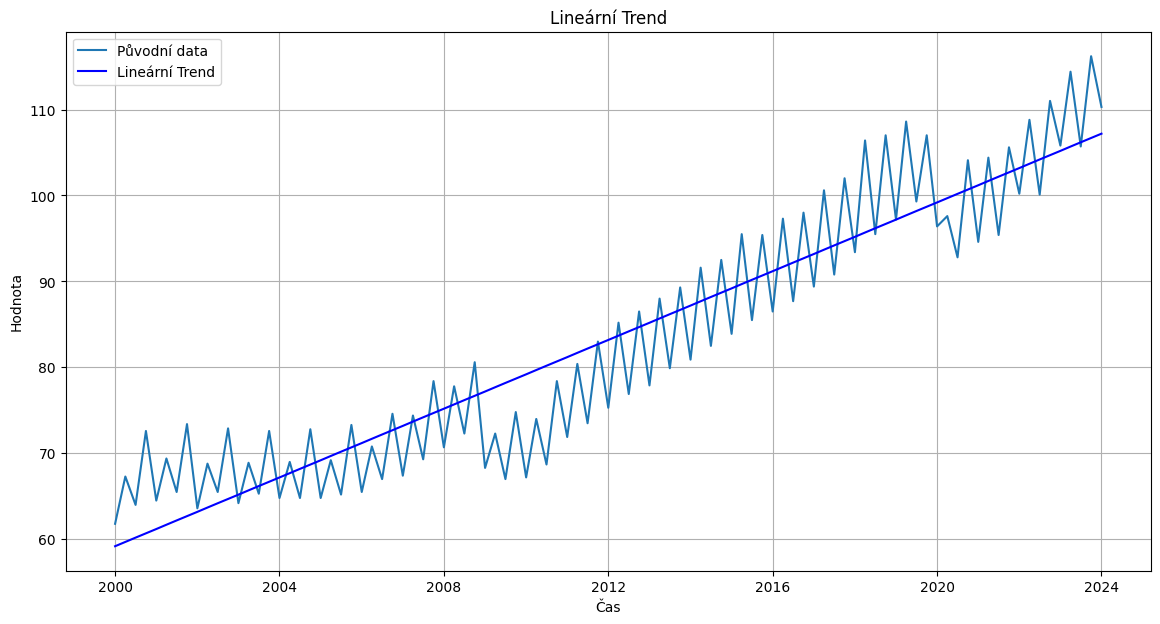

Koeficient Determinace (R²): 0.8601


In [21]:
filtered_data['Time'] = np.arange(len(filtered_data))

model = LinearRegression()
model.fit(filtered_data[['Time']], filtered_data['OBS_VALUE'])
filtered_data['Trend'] = model.predict(filtered_data[['Time']])

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(filtered_data.index, filtered_data['Trend'], color='blue', label='Lineární Trend')
plt.title('Lineární Trend')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Zhodnocení modelu
r_squared = r2_score(filtered_data['OBS_VALUE'], filtered_data['Trend'])
print(f'Koeficient Determinace (R²): {r_squared:.4f}')


##### Po zobrazení trendu a vypsání hodnoty R**2 si dovolím potvrdit, že trend je opravdu vzestupný a můžeme tomu věřit. 

#### b) ARIMA

##### V tomto kroku si vyzkoušíme predikovat hodnoty pomocí ARIMA modelu, který by ale dle vlastností modelu neměl být užit, jelikož se v našich datech objevuje sezónní složka. 

##### Pro zhodnocení modelu využijeme AIC a BIC, které zhodnocují kvalitu i složitost modelu. Zde naopak chceme dosáhnout co nejmenších hodnot.

###### Nižší hodnota AIC naznačuje lepší model, protože model minimalizuje ztrátu informací.

###### Nižší hodnota BIC také signalizuje lepší model, ale penalizace za složitost modelu je silnější než u AIC.


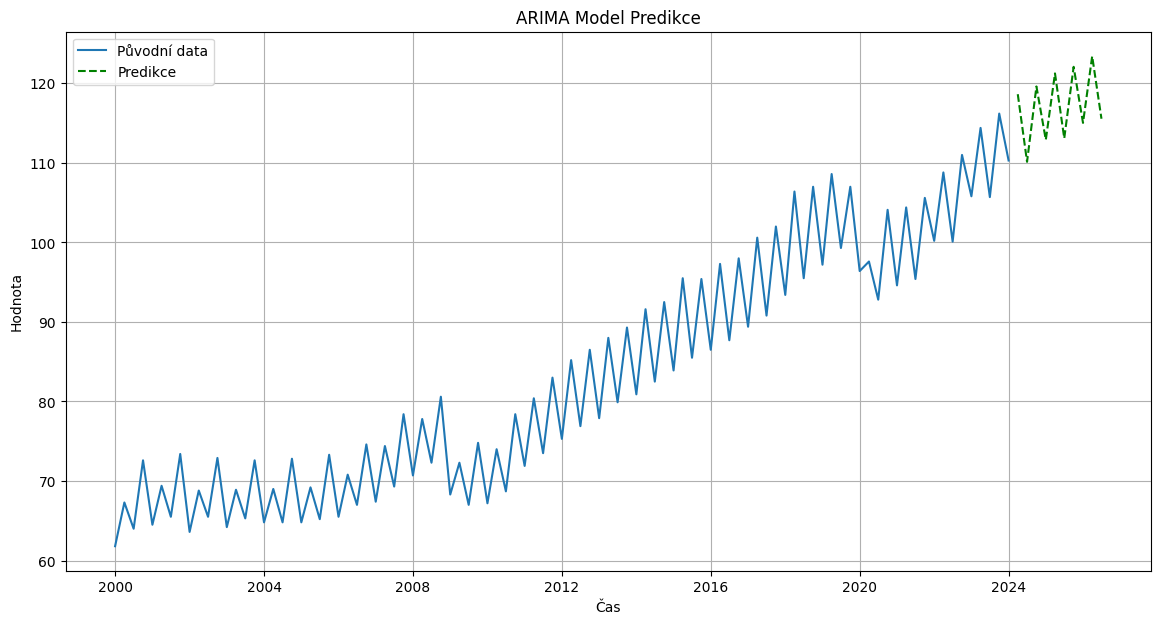

AIC: 403.5321394398886
BIC: 421.4092776810924


In [22]:
# Vytvoření a trénování ARIMA modelu
model = ARIMA(filtered_data['OBS_VALUE'], order=(4, 2, 2))
model_fit = model.fit()

# Predikce (počet period pro predikci)
forecast_periods = 10
forecast = model_fit.forecast(steps=forecast_periods)

# Vytvoření časového indexu pro predikci
forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='Q')

# Vykreslení časové řady a predikcí
plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(forecast_index, forecast, color='green', linestyle='--', label='Predikce')
plt.title('ARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')




##### Po modelování a predikci okem vidíme, že hodnoty stále sotupají, ale už ne tolik jako předtím. 

##### Hodnoty:
- AIC: 403
- BIC: 421

#### 4) Použití SARIMA modelu

##### V dalším kroku využijeme SARIMA modelu, který už bere v potaz sezónní složku

##### Kritéria pro vyhodnocení budou zase AIC a BIC

|   iter    |  target   |     D     |     P     |     Q     |     d     |     p     |     q     |     s     |
-------------------------------------------------------------------------------------------------------------
| 1         | -550.5    | 0.417     | 1.441     | 0.0002287 | 0.3023    | 0.2935    | 0.1847    | 4.0       |
| 2         | -601.7    | 0.3456    | 0.7935    | 1.078     | 0.4192    | 1.37      | 0.4089    | 4.0       |
| 3         | -550.5    | 0.02739   | 1.341     | 0.8346    | 0.5587    | 0.2808    | 0.3962    | 4.0       |
| 4         | -601.7    | 0.9683    | 0.6268    | 1.385     | 0.8764    | 1.789     | 0.1701    | 4.0       |
| 5         | -430.5    | 0.1698    | 1.756     | 0.1967    | 0.4211    | 1.916     | 1.066     | 4.0       |
| 6         | -415.1    | 0.3155    | 1.373     | 1.669     | 0.01829   | 1.5       | 1.978     | 4.0       |
| 7         | -428.7    | 0.2804    | 1.579     | 0.2065    | 0.4479    | 1.817     | 0.5872    | 4.0       |
| 8       

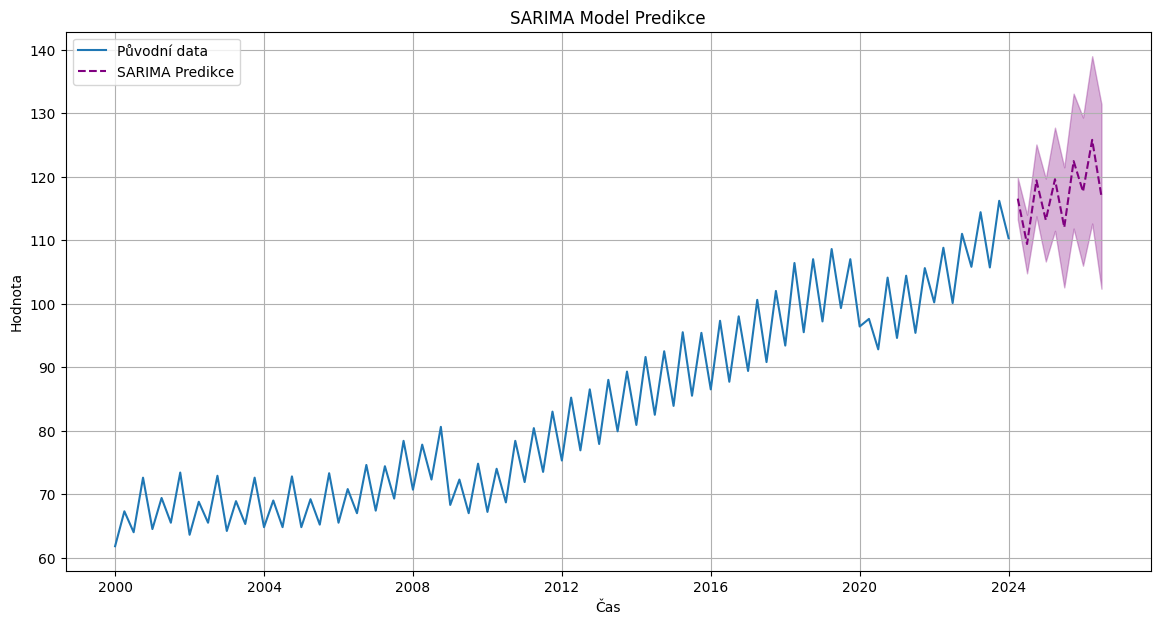

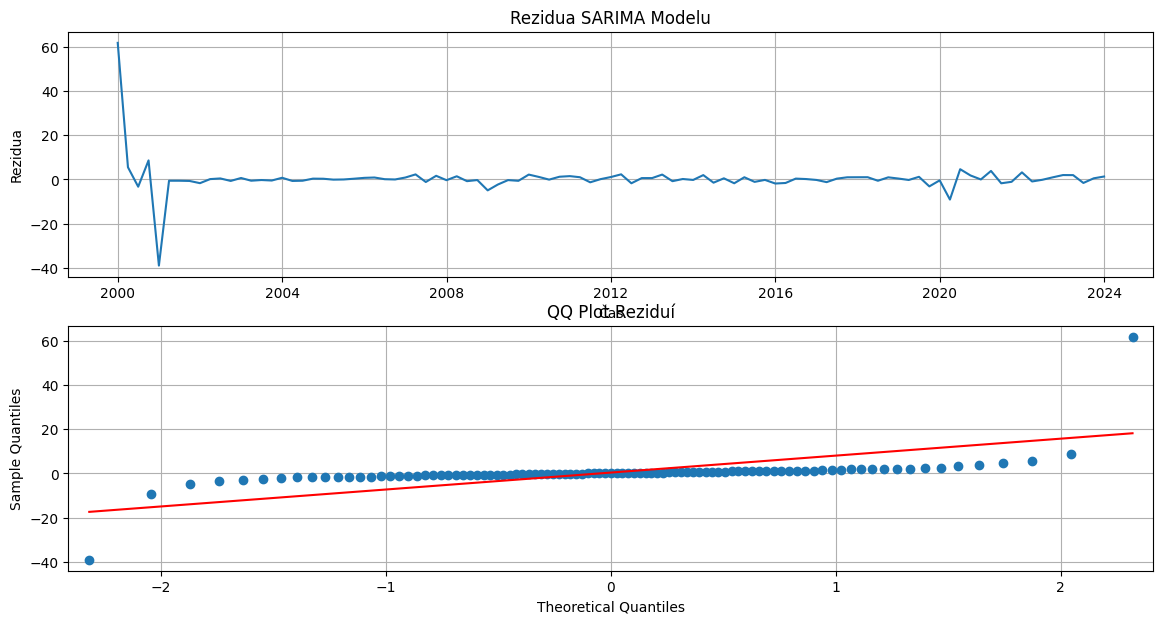

AIC: 373.6453873083577
BIC: 386.2543301936029


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def evaluate_sarima_model(data, p, d, q, P, D, Q, s):
    order = (int(p), int(d), int(q))
    seasonal_order = (int(P), int(D), int(Q), int(s))
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        return -aic  # BayesianOptimization minimalizuje funkci, proto vracíme negativní AIC
    except Exception as e:
        print(f"Chyba při trénování modelu SARIMA s parametry {order} a {seasonal_order}: {e}")
        return np.nan

# Definuj rozsahy hyperparametrů
pbounds = {
    'p': (0, 2),
    'd': (0, 1),
    'q': (0, 2),
    'P': (0, 2),
    'D': (0, 1),
    'Q': (0, 2),
    's': (4, 4)  # Pokud je sezónní cyklus fixní, jinak specifikuj rozmezí
}

# Bayesian optimization
optimizer = BayesianOptimization(
    f=lambda p, d, q, P, D, Q, s: evaluate_sarima_model(filtered_data['OBS_VALUE'], p, d, q, P, D, Q, s),
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=10, n_iter=100)

# Nejlepší parametry
best_params = optimizer.max['params']
print(f'Nejlepší parametry: {best_params}')

# Trénování SARIMA modelu s nejlepšími parametry
best_order = (int(best_params['p']), int(best_params['d']), int(best_params['q']))
best_seasonal_order = (int(best_params['P']), int(best_params['D']), int(best_params['Q']), int(best_params['s']))

sarima_model = SARIMAX(
    filtered_data['OBS_VALUE'],
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarima_model_fit = sarima_model.fit()

# Predikce s SARIMA modelem
sarima_forecast = sarima_model_fit.get_forecast(steps=10)
sarima_forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=10, freq='Q')
sarima_forecast_conf_int = sarima_forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, color='purple', linestyle='--', label='SARIMA Predikce')
plt.fill_between(sarima_forecast_index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Rezidua a QQ plot
residuals = sarima_model_fit.resid
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Rezidua SARIMA Modelu')
plt.xlabel('Čas')
plt.ylabel('Rezidua')
plt.grid(True)

plt.subplot(2, 1, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ Plot Reziduí')
plt.grid(True)
plt.show()

print(f'AIC: {sarima_model_fit.aic}')
print(f'BIC: {sarima_model_fit.bic}')

##### Jak vidíme po výpisu, tak dle hodnot AIC a BIC by tento model měl být lepší, což potvrzuje vhodnost modelu. 

##### Hodnoty:
- AIC: 373
- BIC: 386


##### Tedy dle mého názoru je zde optimální model SARIMA

# 5) Kroskorelace a srovnání modelů

##### V posledním kroku provedeme kroskorelaci pro různé státy, abychom zjistili, zda jsou různé časové řady navzájem propojené.

##### Pomocí kroskorelace můžeme zjistit, zda změny v jedné časové řadě ovlivňují změny v druhé časové řadě a jaký časový posun má největší vliv

##### Následně provedeme srovnání modelů pro různé státy.

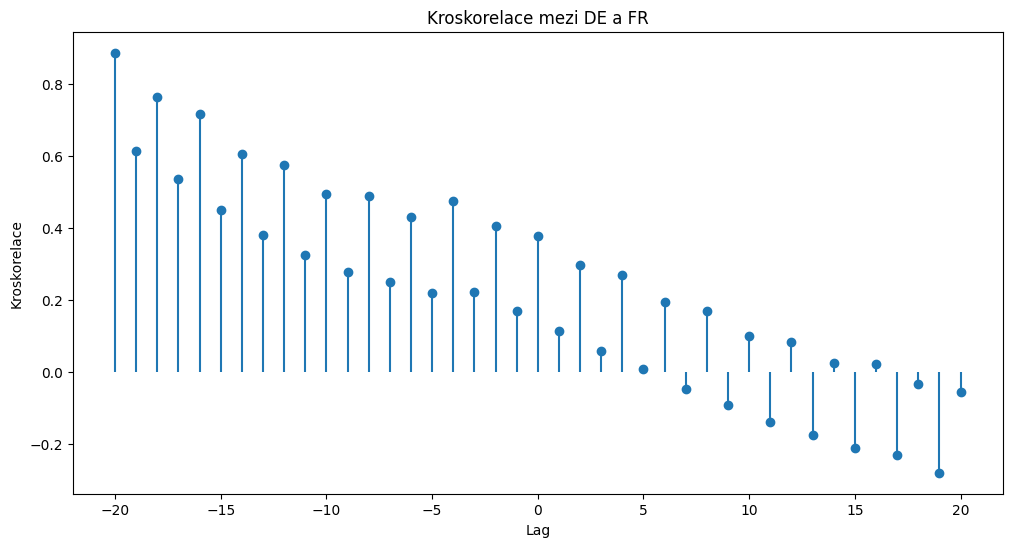

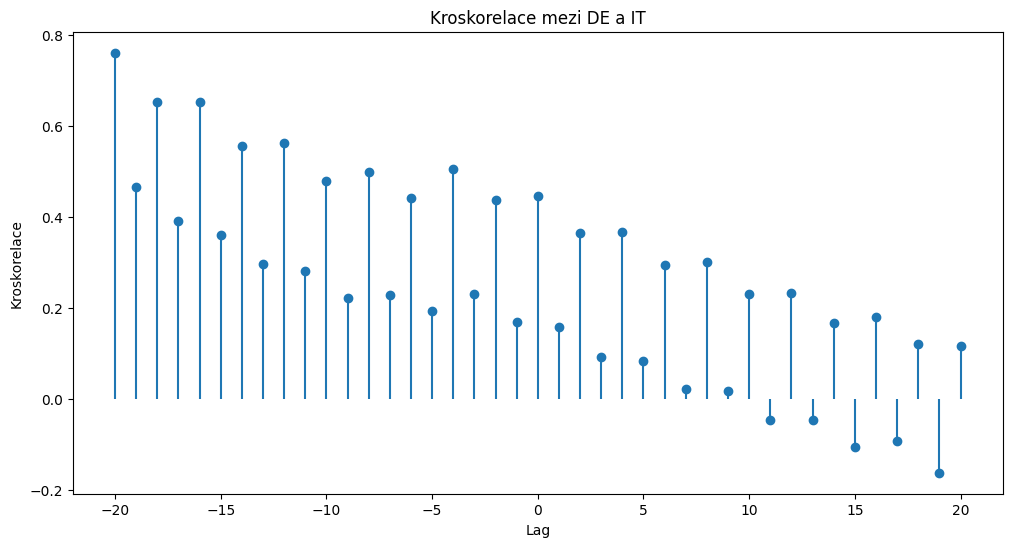

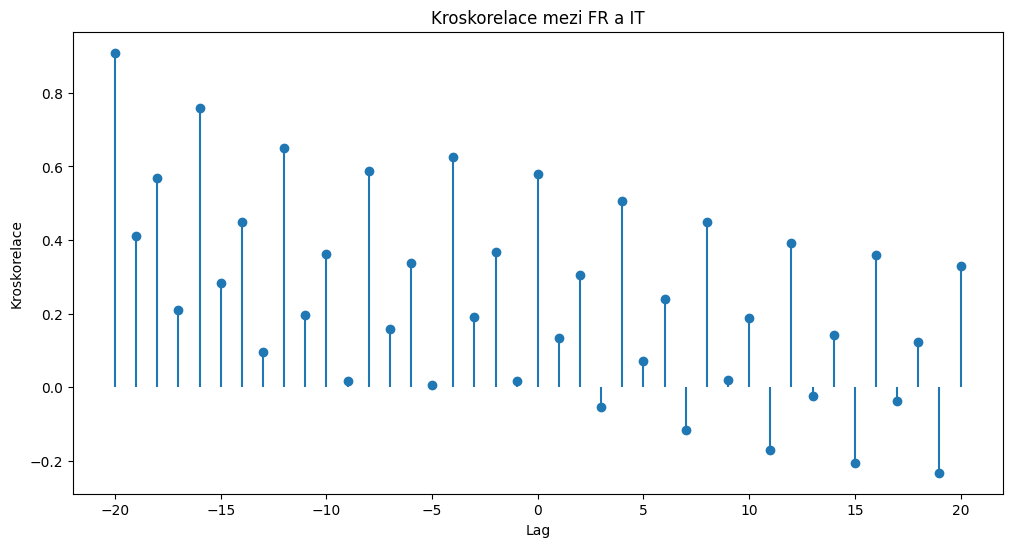

     arima_aic   arima_bic  sarima_aic  sarima_bic
DE  404.758205  432.966035  376.595959  389.204902
FR  433.166467  461.374297  401.603744  414.212686
IT  494.854999  523.062829  455.666017  468.274960


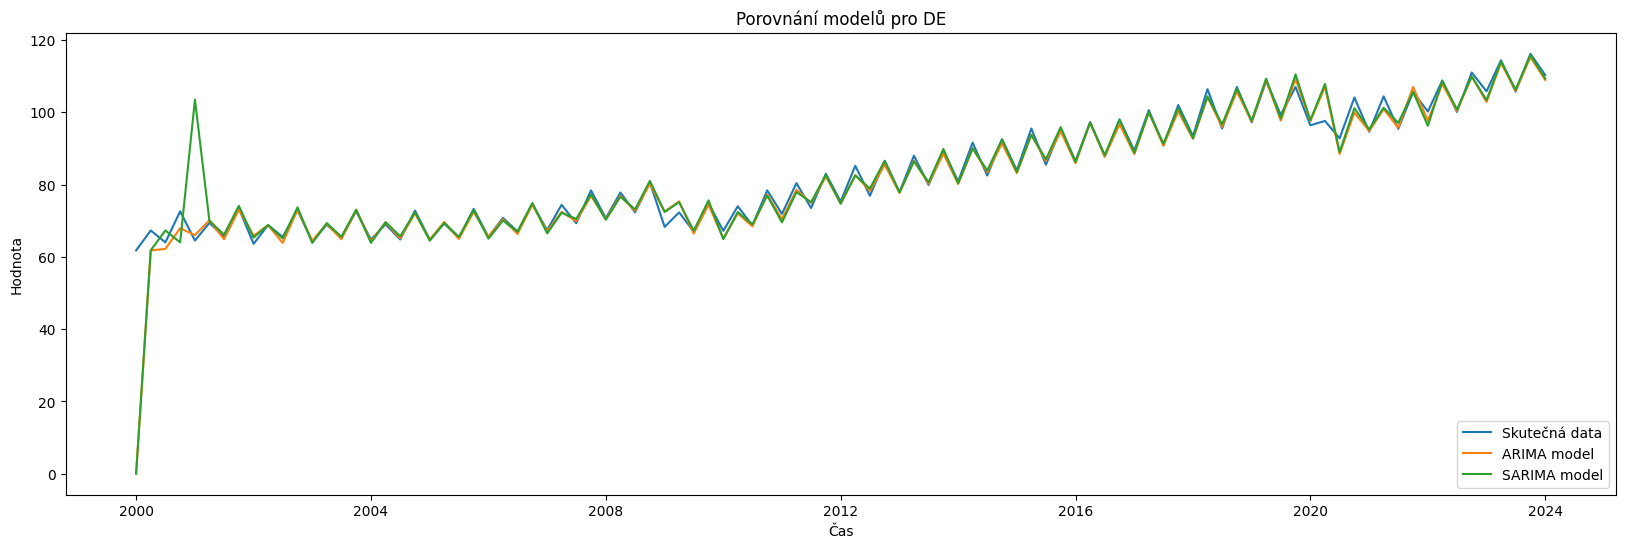

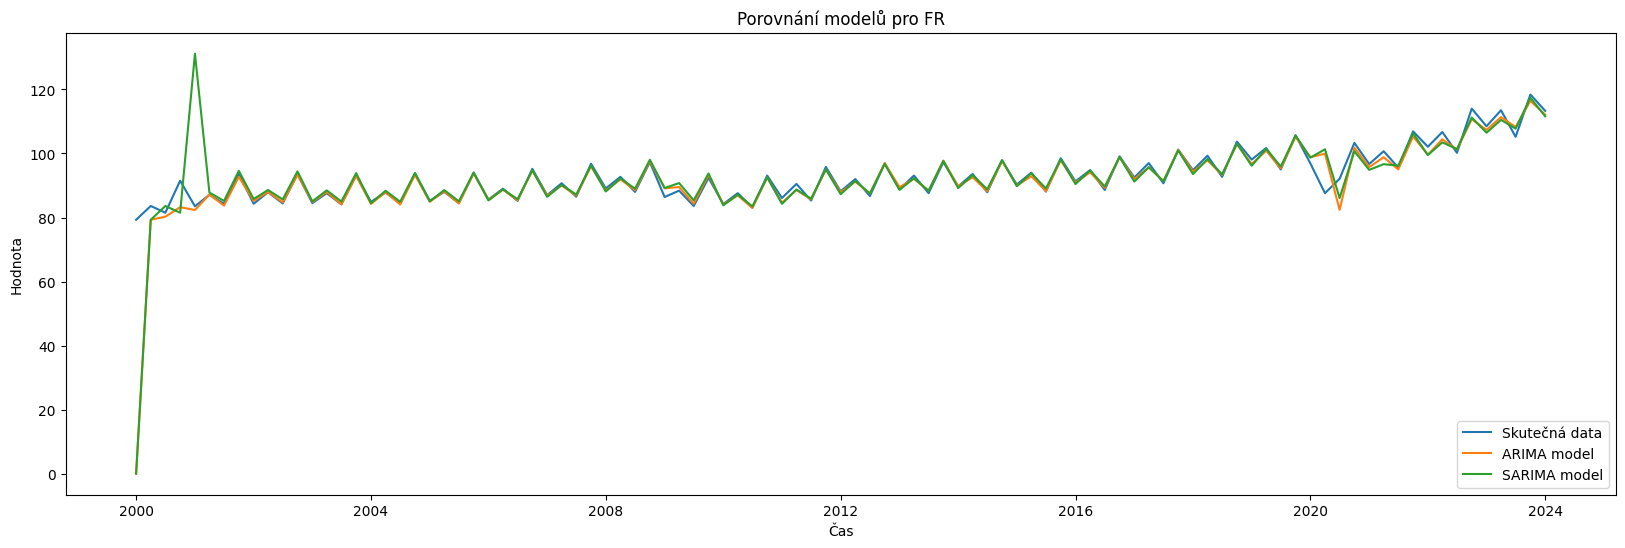

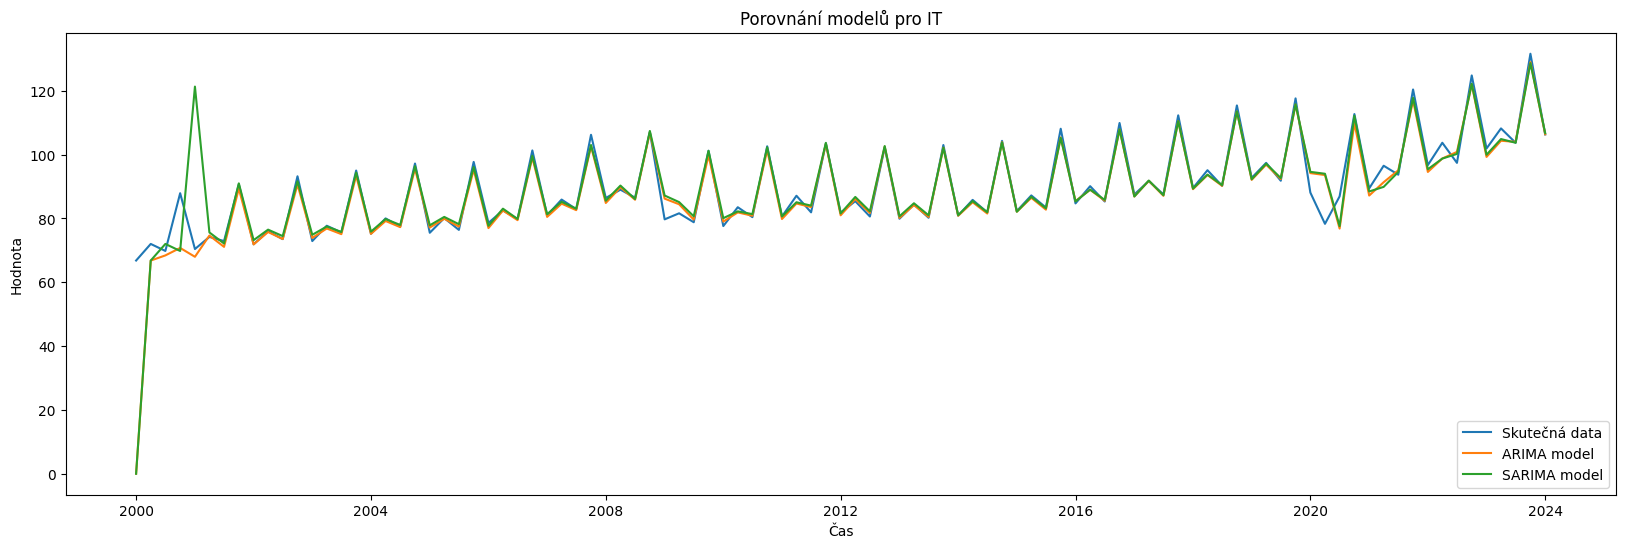

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid

# Načtení původních dat
data = pd.read_csv('ei_isind_q_linear.csv')

data.index.freq = 'Q'
# Seznam geografických označení, které chcete analyzovat
geos = ['DE', 'FR', 'IT']  # Příklad

# Načtení a sloučení dat pro všechny geografické oblasti
all_filtered_data = []
for geo in geos:
    filtered_data = data.loc[
        (data['unit'] == 'I21') & 
        (data['geo'] == geo) & 
        (data['s_adj'] == 'NSA') & 
        (data['indic_bt'] == 'WAGE') & 
        (data['nace_r2'] == 'C')
    ].copy()  # Použití copy(), aby se zabránilo varování
    filtered_data.loc[:, 'geo'] = geo  # Použití .loc pro přiřazení
    all_filtered_data.append(filtered_data)

combined_data = pd.concat(all_filtered_data)

# Převedení TIME_PERIOD na datetime
combined_data['TIME_PERIOD'] = pd.to_datetime(combined_data['TIME_PERIOD'])

# Pivotování dat na formát, který umožňuje analýzu
pivot_data = combined_data.pivot(index='TIME_PERIOD', columns='geo', values='OBS_VALUE')

# Kroskorelace mezi různými geografickými oblastmi
def compute_ccf(series1, series2, max_lag):
    """Compute cross-correlation function values up to a maximum lag."""
    common_dates = series1.index.intersection(series2.index)
    series1 = series1.loc[common_dates]
    series2 = series2.loc[common_dates]
    ccf_values = ccf(series1, series2)
    return ccf_values[:2 * max_lag + 1]

# Použití funkce compute_ccf pro kroskorelaci
geo_pairs = [('DE', 'FR'), ('DE', 'IT'), ('FR', 'IT')]

for geo1, geo2 in geo_pairs:
    series1 = pivot_data[geo1].dropna()
    series2 = pivot_data[geo2].dropna()
    
    if len(series1) > 1 and len(series2) > 1:
        max_lag = 20  # Definujte maximální lag
        ccf_values = compute_ccf(series1, series2, max_lag)
        plt.figure(figsize=(12, 6))
        plt.stem(range(-max_lag, max_lag + 1), ccf_values, basefmt=" ")
        plt.title(f'Kroskorelace mezi {geo1} a {geo2}')
        plt.xlabel('Lag')
        plt.ylabel('Kroskorelace')
        plt.show()
    else:
        print(f'Příliš krátká série pro kroskorelaci mezi {geo1} a {geo2}')

# Funkce pro automatické modelování ARIMA
def fit_arima(series, p=5, d=1, q=5):
    model = ARIMA(series, order=(p, d, q))
    result = model.fit()
    return result

# Funkce pro automatické modelování SARIMA
def fit_sarima(series, p=1, d=1, q=1, seasonal_p=1, seasonal_d=1, seasonal_q=1, s=4):
    model = SARIMAX(series, order=(p, d, q), seasonal_order=(seasonal_p, seasonal_d, seasonal_q, s))
    result = model.fit()
    return result

# Fit ARIMA a SARIMA modely pro každou geografickou oblast
results = {}
for geo in geos:
    series = pivot_data[geo].dropna()
    
    # Fit modelů
    arima_model = fit_arima(series)
    sarima_model = fit_sarima(series)
    
    # Uložení výsledků
    results[geo] = {
        'arima_aic': arima_model.aic,
        'arima_bic': arima_model.bic,
        'sarima_aic': sarima_model.aic,
        'sarima_bic': sarima_model.bic
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by=['arima_aic', 'sarima_aic'], ascending=True, inplace=True)
print(results_df)

# Vizualizace predikcí pro jednotlivé modely
for geo in geos:
    series = pivot_data[geo].dropna()
    
    # Fit modelů
    arima_model = fit_arima(series)
    sarima_model = fit_sarima(series)
    
    # Predikce a fitování
    arima_pred = arima_model.fittedvalues
    sarima_pred = sarima_model.fittedvalues
    
    plt.figure(figsize=(20, 6))
    plt.plot(series, label='Skutečná data')
    plt.plot(pd.Series(arima_pred, index=series.index), label='ARIMA model')
    plt.plot(pd.Series(sarima_pred, index=series.index), label='SARIMA model')
    plt.legend()
    plt.title(f'Porovnání modelů pro {geo}')
    plt.xlabel('Čas')
    plt.ylabel('Hodnota')
    plt.show()
    
    

##### Dle kroskorelace vidíme, že největší vztah:
- pro DE a FR/IT -> zpoždění -20
- pro FR a IT -> zpoždění v -20

##### Z výpisu vidíme jak se oproti sobě liší skutečná data a ARIMA/SARIMA model, na vizualizaci není moc vidět jaký model je lepší, ale hodnoty SARIMA/ARIMA AIC a BIC jsou vždy lepší pro SARIMA model. 